# Factorial

El $n!$ está definido de la siguiente manera:

$$
n! = 1 \times 2 \times 3 \times \cdots \times (n-2) \times (n-1) \times n
$$

Ya sé que por ahí debe haber alguna definición loca de algún matemático ultra *crack* que consiguió alguna definición más seria, pero por lo pronto quedemos en que esta es su definición y que $ n \in N$.

In [1]:
! rm *.c *.o *.so

Como $n \in N$, para la primera implementación en `C` se considerará que `n` es un número entero sin signo, y para poder generar el mayor número posible se emplearán 64 bits.

In [2]:
%%file cla_factorial.c

#include <stdint.h>

uint64_t cla_factorial(uint64_t n) {
    uint64_t p = 1;
    for (uint64_t i = 1; i <= n; i++) {
        p *= i;
    }
    return p;
}

Writing cla_factorial.c


Comandos para crear el *object file* y la *shared library*

In [3]:
! gcc -c cla_factorial.c -o cla_factorial.o

In [4]:
! gcc -shared cla_factorial.o -o cla_factorial.so

Función para enlazar con `ctypes`

In [5]:
import ctypes

In [6]:
def ctypes_cla_factorial():
    # indicar la ruta de la shared library
    libfile = './cla_factorial.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos
    lib.cla_factorial.argtypes = [ctypes.c_uint64]

    # tipo de dato del resultado
    lib.cla_factorial.restype = ctypes.c_uint64
    
    # funcion configurada
    return lib.cla_factorial

Instancia de la función

In [7]:
c_cla_factorial = ctypes_cla_factorial()

Se empleará la función `factorial` del módulo `math` como referencia

In [8]:
import math

In [9]:
c_cla_factorial(5), math.factorial(5)

(120, 120)

In [10]:
c_cla_factorial(15), math.factorial(15)

(1307674368000, 1307674368000)

Parece funcionar bien; sin embargo, recuerde que `Python` no tiene los límites de precisión que sí tiene `C`. Mire lo que pasa cuando se intenta calcular $100!$.

In [11]:
c_cla_factorial(100), math.factorial(100)

(0,
 93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000)

Como puede notar, el resultado es incorrecto. La cuestión más interesante sería saber hasta que valor del factorial sí podemos calcular con nuestra función.

In [12]:
def encontrar_N_max_de_c_cla_factorial():
  N = 1
  while (True):
    dif = c_cla_factorial(N) - math.factorial(N)
    if dif != 0:
      return N-1
    N += 1

In [13]:
N_int = encontrar_N_max_de_c_cla_factorial()

In [14]:
N_int

20

Y se puede comprobar porque al intentar calcular $21!$ sale lo siguiente

In [15]:
c_cla_factorial(21), math.factorial(21)

(14197454024290336768, 51090942171709440000)

Lamentablemente con esta aproximación solo podemos calcular hasta el $20!$. ¿Qué se tendría que hacer si se necesita calcular el factorial de un número más grande?

Se puede emplear una definición alternativa del factorial

Usted sabe que:
$$
n! = 1 \times 2 \times 3 \times \cdots \times (n-2) \times (n-1) \times n
$$
Si se toma $ln$ a ambos lados de la igualdad:
$$
ln(n!) = ln(1) + ln(2) + ln(3) + \cdots + ln(n-2) + ln(n-1) + ln(n)
$$
Y por propiedad se sabe que:
$$
e^{ln(x)} = x
$$
Entonces:
$$
n! = e^{ln(1) + ln(2) + ln(3) + \cdots + ln(n-2) + ln(n-1) + ln(n)}
$$

Como puede notar, esta aproximación nos permite utilizar números en coma flotante, y esto nos da la libertad de trabajar con  `float`, `double` o `long double`. 

In [16]:
%%file log_factorial.c

#include <stdint.h>
#include <math.h>

float log_factorial_float(uint64_t n) {
    float res = 0.0;
    for (uint64_t i = 2; i <= n; i++) {
        res += logf((float)i);
    }
    return expf(res);
}

double log_factorial_double(uint64_t n) {
    double res = 0.0;
    for (uint64_t i = 2; i <= n; i++) {
        res += log((double)i);
    }
    return exp(res);
}

long double log_factorial_longdouble(uint64_t n) {
    long double res = 0.0;
    for (uint64_t i = 2; i <= n; i++) {
        res += logl((long double)i);
    }
    return expl(res);
}

Writing log_factorial.c


Comandos para crear el *object file* y la *shared library*

In [17]:
! gcc -c log_factorial.c -o log_factorial.o -lm

In [18]:
! gcc -shared log_factorial.o -o log_factorial.so

Función para el enlace con `ctypes`

In [19]:
def ctypes_log_factorial():
    # indicar la ruta de la shared library
    libfile = './log_factorial.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos de la función con float
    lib.log_factorial_float.argtypes = [ctypes.c_uint64]

    # tipo de dato del resultado de la función con float
    lib.log_factorial_float.restype = ctypes.c_float

    # tipo de dato de los argumentos de la función con double
    lib.log_factorial_double.argtypes = [ctypes.c_uint64]

    # tipo de dato del resultado de la función con double
    lib.log_factorial_double.restype = ctypes.c_double

    # tipo de dato de los argumentos de la función con long double
    lib.log_factorial_longdouble.argtypes = [ctypes.c_uint64]

    # tipo de dato del resultado de la función con long double
    lib.log_factorial_longdouble.restype = ctypes.c_longdouble
    
    # funciones configuradas
    return lib.log_factorial_float, lib.log_factorial_double, lib.log_factorial_longdouble

Instancias de las tres funciones

In [20]:
c_log_factorial_float, c_log_factorial_double, c_log_factorial_longdouble = ctypes_log_factorial()

Como ahora se trabaja con números en punto flotante esto permite hacer un seguimiento de la precisión del cálculo que se está realizando, y al mismo tiempo se pondrá saber el mayor valor de $n!$ que se puede calcular

In [21]:
def encontrar_N_max_de_c_log_factorial(f):
  N = 1
  while (True):
    try:
      err = abs(f(N) - math.factorial(N)) / abs(math.factorial(N))
      print(f'Se pudo calcular el factorial de {N} con un error de {err}')
      if err == float('inf'):
        return N-1
      N += 1
      continue 
    except OverflowError:
      print(f'Ocurre un desborde de tipo de dato cuando N vale {N}')
      return N-1 

In [ ]:
N_float = encontrar_N_max_de_c_log_factorial(c_log_factorial_float)

In [23]:
N_float

34

In [ ]:
N_double = encontrar_N_max_de_c_log_factorial(c_log_factorial_double)

In [25]:
N_double

170

In [ ]:
N_longdouble = encontrar_N_max_de_c_log_factorial(c_log_factorial_longdouble)

In [27]:
N_longdouble

170

Como puede notar, cuando se usa `float` solo se puede calcular hasta $35!$, pero con `double` y `long double` se puede hasta `170!`. Con esta información ya se puede hacer un análisis del impacto que tiene en el tiempo de ejecución.

In [28]:
import time

In [29]:
import statistics

Con esta función se puede encontrar la mediana de los tiempos de una función `func` que recibe como argumento `f_arg1`, luego de haber realizado `num_iter` iteraciones.

In [30]:
def encontrar_mediana_de_mediciones(func, f_arg1, num_iter):
  t = []
  for i in range(num_iter):
    # se empieza a medir el tiempo de la función func con su argumento
    tic = time.perf_counter()
    # se llama a la función de Python
    func(f_arg1)
    # se termina de medir el tiempo de la función func con su argumento
    toc = time.perf_counter()
    # se guarda la medición en la lista de Python
    t.append(toc-tic)

  return statistics.median(t)

Medianas de tiempos para el máximo valor que permite la función original que solo trabaja con enteros sin signo, y sus contrapartes con números en punto flotante para 25 iteraciones.

In [31]:
num_iter = 25

In [32]:
t_cf_med = encontrar_mediana_de_mediciones(c_cla_factorial, N_int, num_iter)
t_lf_f_med = encontrar_mediana_de_mediciones(c_log_factorial_float, N_int, num_iter)
t_lf_d_med = encontrar_mediana_de_mediciones(c_log_factorial_double, N_int, num_iter)
t_lf_ld_med = encontrar_mediana_de_mediciones(c_log_factorial_longdouble, N_int, num_iter)

In [33]:
import matplotlib.pyplot as plt

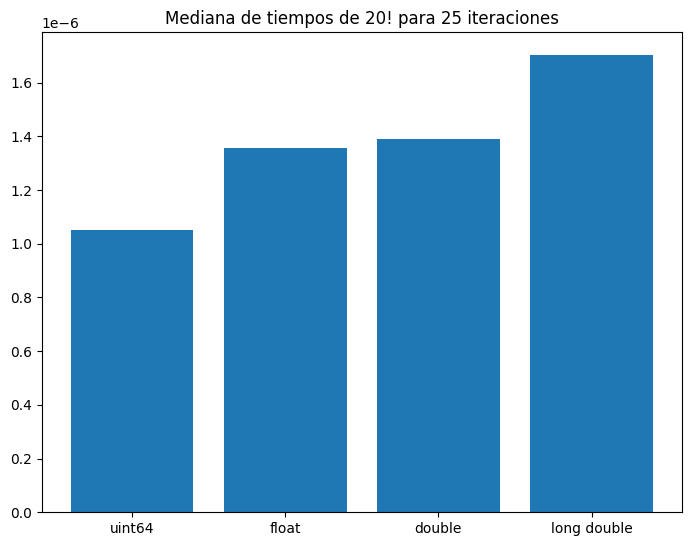

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
casos = ['uint64', 'float', 'double', 'long double']
ax.bar(casos, [t_cf_med, t_lf_f_med, t_lf_d_med, t_lf_ld_med])
plt.title(f'Mediana de tiempos de {N_int}! para {num_iter} iteraciones')
plt.show()

Como puede notar, las funciones que calculan el factorial empleando la función exponencial y el logaritmo tienen un tiempo de ejecución mayor que la versión original con enteros. ¿Qué ocurrirá cuando se comparen solo entre ellas?

In [35]:
t_lf_f_med = encontrar_mediana_de_mediciones(c_log_factorial_float, N_float, num_iter)
t_lf_d_med = encontrar_mediana_de_mediciones(c_log_factorial_double, N_float, num_iter)
t_lf_ld_med = encontrar_mediana_de_mediciones(c_log_factorial_longdouble, N_float, num_iter)

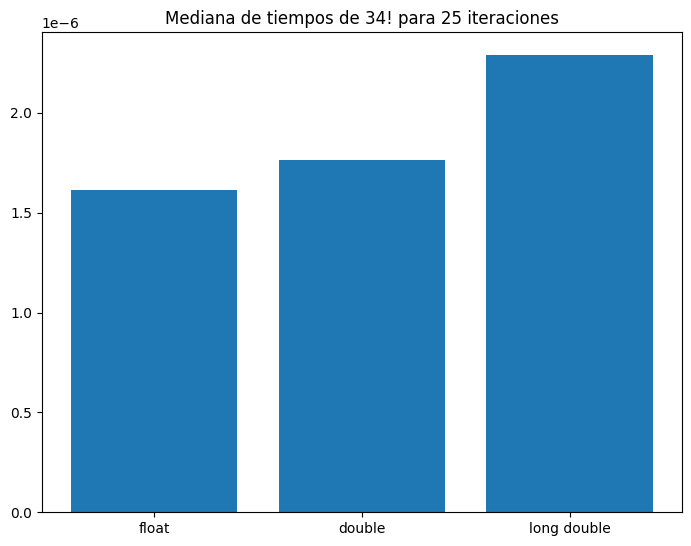

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
casos = ['float', 'double', 'long double']
ax.bar(casos, [t_lf_f_med, t_lf_d_med, t_lf_ld_med])
plt.title(f'Mediana de tiempos de {N_float}! para {num_iter} iteraciones')
plt.show()

In [37]:
t_lf_d_med = encontrar_mediana_de_mediciones(c_log_factorial_double, N_double, num_iter)
t_lf_ld_med = encontrar_mediana_de_mediciones(c_log_factorial_longdouble, N_double, num_iter)

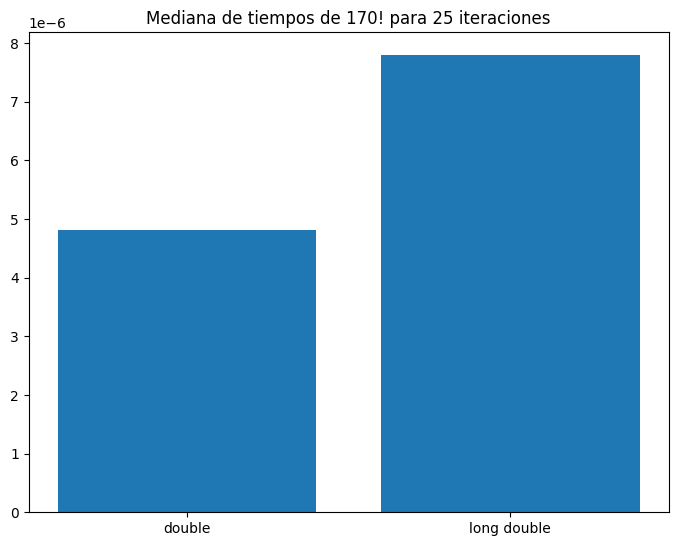

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
casos = ['double', 'long double']
ax.bar(casos, [t_lf_d_med, t_lf_ld_med])
plt.title(f'Mediana de tiempos de {N_double}! para {num_iter} iteraciones')
plt.show()

Es cierto, el tiempo de ejecución incrementó considerablemente, pero ahora se pueden calcular factoriales de números mayores al $20$. Sacrificar tiempo de ejecución, a cambio de ganar precisión y capacidad de cálculo será un situación usual al momento de implementar soluciones. No siempre se debe dar prioridad a un menor tiempo de ejecución.

Si usted tuviera que calcular $160!$ ¿Cuál sería la alternativa conveniente?